# Scraping stock info from Naver Stock

In [1]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from urllib.parse import quote
import requests
import datetime as dt
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import re

## Target

In [1]:
summer_theme = {
    '060310' : '3S',
    '051900' : 'LG생활건강',
    '025860' : '남해화학',
    '071460' : '대유위니아',
    '088910' : '동우팜투테이블',
    '060570' : '드림어스컴퍼니',
    '280360' : '롯데제과',
    '005300' : '롯데칠성',
    '002270' : '롯데푸드',
    '071840' : '롯데하이마트',
    '027740' : '마니커',
    '267790' : '배럴',
    '000890' : '보해양조',
    '005180' : '빙그레',
    '002700' : '신일산업',
    '042110' : '에스씨디',
    '043340' : '에쎈테크',
    '067170' : '오텍',
    '021240' : '웅진코웨이',
    '044340' : '위닉스',
    '035810' : '이지바이오',
    '001550' : '조비',
    '284740' : '쿠쿠홈시스',
    '006890' : '태경화학',
    '037070' : '파세코',
    '027710' : '팜스토리',
    '136480' : '하림',
    '000080' : '하이트진로'
}

## Scraping stock index data

In [3]:
def date_format(d):
    d = str(d).replace('-', '.')
    yyyy = int(d.split('.')[0])
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])
    
    this_date = dt.date(yyyy, mm, dd)
    return this_date

- Korean stock index data (from NAVER)

In [4]:
def read_json(d, symbol, page=1):
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol=' + symbol + '&fdtc=0&page=' + str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    for n in range(len(data)):
        date = pd.to_datetime(data[n]['xymd']).date()
        price = float(data[n]['clos'])
        d[date] = price
        
    if len(data) == 10:
        page += 1
        read_json(d, symbol, page)
        
    return d

In [5]:
def date_format(d=''):
    if d != '':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date()
    return (this_date)

In [6]:
url = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930'
source = urlopen(url).read()
soup = bs(source, 'lxml')

In [7]:
tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
tmp = tmp.replace('\r', '').replace('\n','').replace('\t','')
tmp = re.split('/', tmp)
tmp

['5,969,782,550주 ', ' 78.79%']

In [8]:
outstanding = tmp[0].replace(',','').replace('주','').replace(' ','')
outstanding = int(outstanding)

In [9]:
floating = tmp[1].replace(' ','').replace('%','')
floating = float(floating)

In [10]:
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '').replace('\n','').replace('\t','')
    tmp = re.split('/', tmp)
                   
    outstanding = tmp[0].replace(',','').replace('주','').replace(' ','')
    outstanding = int(outstanding)
                   
    floating = tmp[1].replace(' ','').replace('%','')
    floating = float(floating)
                   
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    stock_outstanding[stock_cd] = outstanding
    stock_floating[stock_cd] = floating
    stock_name[stock_cd] = name

In [11]:
stock_outstanding = dict()
stock_floating = dict()
stock_name = dict()
for stock_cd in summer_theme.keys():
    stock_info(stock_cd)

In [12]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
    
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()
    source = bs(source, 'lxml')
    
    dates = source.find_all('td', class_='date')
    prices = source.find_all('td', class_='number_1')
    
    for n in range(len(dates)):
        if dates[n].text.split('.')[0].isdigit():
            
            # Handling date
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                
                # Handling closing price
                this_close = prices[n*4].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
                
                historical_prices[this_date] = this_close

            elif this_date < start_date:
                return historical_prices
            
    
    # Navigating page
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page)
        
    if page_n < last_page:
        page_n += 1
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)
        
    return historical_prices

In [13]:
def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
    
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    #source = requests.get(naver_stock)
    source = bs(source, 'lxml')
    
    dates = source.find_all('span', class_='tah p10 gray03')
    prices = source.find_all('td', class_='num')
    
    for n in range(len(dates)):
        
        if len(dates) > 0:
            
            # Handling date
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                
                # Handling closing price
                this_close = prices[n*6].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
                
                historical_prices[this_date] = this_close

            elif this_date < start_date:
                return historical_prices
            
    
    # Navigating page
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page)
        
    if page_n < last_page:
        page_n += 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)
        
    return historical_prices

In [14]:
start_date = '2018-1-1'
end_date = '2018-12-31'

In [15]:
theme_historical_prices = dict()

for stock_cd in summer_theme.keys():
    historical_prices = dict()
    historical_stock_naver(stock_cd, start_date, end_date)
    
    theme_historical_prices[stock_cd] = historical_prices
    
theme_historical_price = pd.DataFrame(theme_historical_prices)
theme_historical_price.sort_index(axis=1, inplace=True)

theme_historical_price = theme_historical_price.fillna(method='ffill')
if theme_historical_price.isnull().values.any():
    theme_historical_price = theme_historical_price.fillna(method='bfill')
theme_historical_price.head()

,000080,000890,001550,002270,002700,005180,005300,006890,021240,025860,...,060310,060570,067170,071460,071840,088910,136480,267790,280360,284740
2018-12-28,16600.0,1890.0,23200.0,709000.0,1305.0,72500.0,1400000.0,4640.0,74100.0,11500.0,...,2215.0,6760.0,10500.0,2600.0,46650.0,3745.0,2800.0,9980.0,151000.0,177500.0
2018-12-27,16950.0,2280.0,22450.0,717000.0,1285.0,74300.0,1405000.0,4560.0,73500.0,11500.0,...,2240.0,6930.0,10250.0,2470.0,46650.0,3735.0,2710.0,9230.0,156000.0,176500.0
2018-12-26,17550.0,1830.0,22100.0,705000.0,1280.0,73000.0,1413000.0,4555.0,76000.0,11150.0,...,2195.0,6880.0,10000.0,2155.0,48250.0,3640.0,2680.0,9120.0,156000.0,165000.0
2018-12-24,17750.0,1870.0,23600.0,719000.0,1295.0,75500.0,1447000.0,4650.0,76300.0,11500.0,...,2150.0,6820.0,10350.0,2245.0,48550.0,3715.0,2770.0,9600.0,159500.0,168000.0
2018-12-21,18000.0,2100.0,23700.0,721000.0,1300.0,75200.0,1450000.0,4680.0,78400.0,11400.0,...,2160.0,6630.0,10650.0,2260.0,48400.0,3695.0,2850.0,9960.0,162500.0,173500.0


In [16]:
tmp = {'Outstanding' : stock_outstanding,\
       'Floating' : stock_floating,\
       'Price' : theme_historical_price.iloc[0],\
       'Name' : stock_name}
theme_info = pd.DataFrame(tmp)

In [17]:
theme_info['f Market Cap'] = theme_info['Outstanding'] * theme_info['Floating'] * theme_info['Price'] * 0.01
theme_info['Market Cap'] = theme_info['Outstanding'] * theme_info['Price'] * 0.01
theme_info.head(2)

,Outstanding,Floating,Price,Name,f Market Cap,Market Cap
000080,70133611,43.59,16600.0,하이트진로,5.074826e+11,1.164218e+10
000890,127449373,73.22,1890.0,보해양조,1.763718e+11,2.408793e+09


In [18]:
theme_historical_mc = theme_historical_price * theme_info['Outstanding'] * theme_info['Floating'] * 0.01
theme_historical_mc.head(2)

,000080,000890,001550,002270,002700,005180,005300,006890,021240,025860,...,060310,060570,067170,071460,071840,088910,136480,267790,280360,284740
2018-12-28,5.074826e+11,1.763718e+11,3.979997e+10,2.579222e+11,7.781739e+10,3.489654e+11,4.673296e+12,2.045850e+10,4.000792e+12,2.314935e+11,...,9.078252e+10,1.127365e+11,1.063083e+11,3.842530e+10,4.238903e+11,4.517756e+10,1.220774e+11,3.982083e+10,2.018269e+11,9.733538e+11
2018-12-27,5.181825e+11,2.127660e+11,3.851333e+10,2.608324e+11,7.662479e+10,3.576294e+11,4.689987e+12,2.010577e+10,3.968397e+12,2.314935e+11,...,9.180716e+10,1.155716e+11,1.037771e+11,3.650403e+10,4.238903e+11,4.505693e+10,1.181535e+11,3.682828e+10,2.085099e+11,9.678701e+11


In [19]:
theme = pd.DataFrame()
theme['Theme Market Cap'] = theme_historical_mc.sum(axis=1)
theme.sort_index(inplace=True)
theme['index'] = theme['Theme Market Cap'] / theme['Theme Market Cap'][0] * 100

In [20]:
historical_prices = dict()
kospi200 = historical_index_naver('KPI200', start_date, end_date)
k200 = pd.DataFrame({'K200':kospi200})

C:\Users\space\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


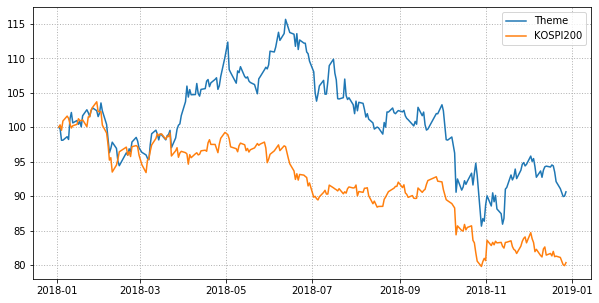

In [21]:
plt.figure(figsize=(10,5))
plt.plot(theme['index'] / theme['index'][0] * 100, label='Theme')
plt.plot(k200['K200'] / k200['K200'][0] * 100, label='KOSPI200')
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

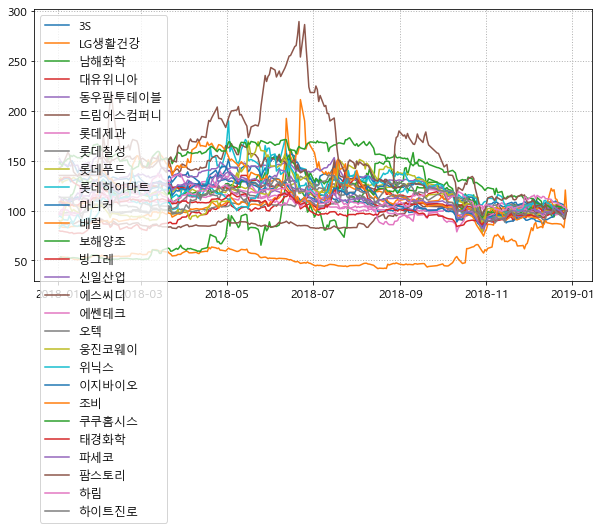

In [22]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
for i in range(len(summer_theme)):
    v = theme_historical_mc.iloc[:, i]
    plt.plot(v/v[0]*100, label=list(summer_theme.values())[i])

plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)